In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model = 'deepseek-r1-distill-llama-70b',
    temperature=0.3
)

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001FC34962720>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001FC34554B00>, model_name='deepseek-r1-distill-llama-70b', temperature=0.3, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
llm.invoke("hello, how are you?")

AIMessage(content="<think>\n\n</think>\n\nHello! I'm just a virtual assistant, so I don't have feelings, but I'm here and ready to help you with whatever you need. How are you doing? 😊", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 9, 'total_tokens': 51, 'completion_time': 0.176880671, 'prompt_time': 0.000191567, 'queue_time': 0.052937713000000004, 'total_time': 0.177072238}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--3c21f66b-4e4d-4db5-9dcb-d45b3f99d352-0', usage_metadata={'input_tokens': 9, 'output_tokens': 42, 'total_tokens': 51})

In [4]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

In [5]:
def add_number(state):
    result = state["num1"] + state["num2"]
    print(f"addition is {result}")
    
    return Command(goto="multiply", update={"sum":result})

In [6]:
state = {"num1":10,"num2":20}

add_number(state)

addition is 30


Command(update={'sum': 30}, goto='multiply')

#### **Dummy Multi-Agent:**

In [7]:
from langchain_core.tools import tool

In [8]:
# Define tools for agent communication
@tool
def transfer_to_multiplication_expert() -> str:
    """Transfer the query to the multiplication expert for precise calculations."""
    return "This question involves multiplication. Please handle it using the multiplication expert agent."

@tool
def transfer_to_addition_expert() -> str:
    """Transfer the query to the addition expert for summation-related help."""
    return "This question involves addition. Please route it to the addition expert agent."

In [9]:
llm_with_tool = llm.bind_tools([transfer_to_addition_expert])

In [10]:
response = llm_with_tool.invoke("hi")

In [11]:
response.content

'Hello! How can I assist you today?'

In [12]:
response = llm_with_tool.invoke("what is 2+2?")

In [13]:
response.content

''

In [14]:
response.tool_calls

[{'name': 'transfer_to_addition_expert',
  'args': {},
  'id': '73vsvmjfv',
  'type': 'tool_call'}]

In [15]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '73vsvmjfv', 'function': {'arguments': '{}', 'name': 'transfer_to_addition_expert'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 159, 'prompt_tokens': 131, 'total_tokens': 290, 'completion_time': 0.666555547, 'prompt_time': 0.008438202, 'queue_time': 0.052653676, 'total_time': 0.674993749}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b8ea5c5b-fea3-4a8d-9bf0-0b3f11a24aed-0', tool_calls=[{'name': 'transfer_to_addition_expert', 'args': {}, 'id': '73vsvmjfv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 131, 'output_tokens': 159, 'total_tokens': 290})

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hL5vUB9UrYGIIAD5EoQCaM2f', 'function': {'arguments': '{}', 'name': 'transfer_to_addition_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 48, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-BpIYSqeYDDkPLrS81hasn83V7VCKR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--0a38df7e-f590-4481-bbdb-e9bfa9de9684-0', tool_calls=[{'name': 'transfer_to_addition_expert', 'args': {}, 'id': 'call_hL5vUB9UrYGIIAD5EoQCaM2f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 48, 'output_tokens': 14, 'total_tokens': 62, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [16]:
system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )

messages = [{"role": "system", "content": system_prompt}] + ["can you tell me the addition of 2 and 2?"]
messages

[{'role': 'system',
  'content': 'You are an addition expert, you can ask the multiplication expert for help with multiplication.Always do your portion of calculation before the handoff.'},
 'can you tell me the addition of 2 and 2?']

In [17]:
from typing_extensions import Literal
from langgraph.graph import MessagesState, StateGraph, START, END

In [18]:
# Agent 1: Addition Expert
def addition_agent(state: MessagesState) -> Command[Literal["multiplication_agent", "__end__"]]:
    system_prompt = (
        "You are an addition expert. You can ask the multiplication expert for help with multiplication. "
        "Always do your portion of calculation before the handoff. "
        "If the question involves both addition and multiplication, do the addition first, then transfer to multiplication expert."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred to multiplication expert",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_agent", 
            update={"messages": state["messages"] + [ai_msg, tool_msg]}
        )
    
    return {"messages": state["messages"] + [ai_msg]}

In [19]:
# Agent 2: Multiplication Expert
def multiplication_agent(state: MessagesState) -> Command[Literal["addition_agent", "__end__"]]:
    system_prompt = (
        "You are a multiplication expert. You can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff. "
        "If the question involves both multiplication and addition, do the multiplication, then transfer to addition expert if needed."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred to addition expert",
            "tool_call_id": tool_call_id,
        }
        return Command(
            goto="addition_agent", 
            update={"messages": state["messages"] + [ai_msg, tool_msg]}
        )
    
    return {"messages": state["messages"] + [ai_msg]}

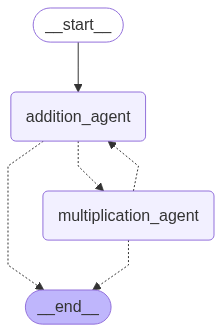

In [20]:
# Create the graph
graph = StateGraph(MessagesState)

# Add nodes
graph.add_node("addition_agent", addition_agent)
graph.add_node("multiplication_agent", multiplication_agent)

# Add edges
graph.add_edge(START, "addition_agent")

# Compile the app
app = graph.compile()
app

In [21]:
# Test the system
print("Testing the multi-agent system...")
print("=" * 50)

events = app.stream(
    {
        "messages": [("user", "What is the result of (3 + 5) * 12? Then, multiply that result by 13 and provide the final answer.")]
    },
    stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

Testing the multi-agent system...
================================ Human Message =================================

What is the result of (3 + 5) * 12? Then, multiply that result by 13 and provide the final answer.
================================= Tool Message =================================

Successfully transferred to multiplication expert
================================== Ai Message ==================================

The result of (3 + 5) * 12 is 96. Multiplying that result by 13 gives a final answer of 1248.

Step-by-step explanation:

1. Calculate the sum inside the parentheses:
   \[
   3 + 5 = 8
   \]

2. Multiply the sum by 12:
   \[
   8 \times 12 = 96
   \]

3. Multiply the result by 13:
   \[
   96 \times 13 = 1248
   \]

Final answer: 1248
